In [1]:
from gw_signal_tools.inner_product import inner_product, norm, overlap
from gw_signal_tools.PSDs import psd_gw150914

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


# Inner Product Verifications

First we need example signals

In [2]:
# Define the dictionary
# deltaT = 1./1024.*u.s
# deltaT = 1./2048.*u.s
deltaT = 1./4096.*u.s
f_min = 20.*u.Hz  # Cutoff frequency
f_ref = 20.*u.Hz  # Frequency where we specify spins
distance = 440.*u.Mpc
inclination = 2.7*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : deltaT,
    # 'deltaF' : deltaT / u.s * u.Hz,  # Does work
    'f22_start' : f_min,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate waveform -> output are two time series, h_plus and h_cross
hp_t, hc_t = wfm.GenerateTDWaveform(parameters_gw150914, gen)

# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)

hp_f_coarse, hc_f_coarse = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


To show the difference in sampling, let us look at the values

In [3]:
print(hp_f_coarse.df, hp_f_fine.df)

0.5838916607270136 Hz 0.0625 Hz


This is almost one order of magnitude difference

In [4]:
# df_test = hp_f_coarse.df / 2  # Without 1/2 assertion error
# df_test = 0.125  # Testing of df parameter
# df_test = 0.125 * u.Hz  # Testing of df parameter -> results not even too bad
df_test = 0.001  # Error for all three calls
# df_test = 2**-10  # Smaller number, but no error
df_test = None
# f_range_test = [f_min, 250]  # Activating makes results slightly more unequal
# f_range_test = [0, 250000]  # Testing of range parameter
f_range_test = None

print(norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test))
print(norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test))
print(norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test))

29.753670381158557
29.75382206975821
29.632756613079803


In [5]:
print(overlap(hp_t, hp_f_coarse, psd_gw150914))
print(overlap(hp_t, hp_f_fine, psd_gw150914))

0.9996911301802703
0.9999994139733958


As we can see, sampling of input makes a notable difference because the quality of interpolation depends on that.

Nonetheless, all results are consistent and even the ones for coarser sampling are acceptable with the overlap being greater than $0.999$.

We can also demonstrate the influence of the PSD on inner product values and thus the SNR.

In [6]:
from gw_signal_tools.PSDs import psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim

In [7]:
for psd in [psd_gw150914, psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim]:
    print(f'SNR for {psd.name}: {norm(hp_f_fine, psd, f_range=[f_min, None])}')

SNR for PSD around GW150914: 29.75382206975821
SNR for Typical PSD of Hanford detector in O3: 48.48046394692113
SNR for Typical PSD of Livingston detector in O3: 56.548454454284276
SNR for Typical PSD of VIRGO detector in O3: 24.404945725530467
SNR for PSD values as simulated by `SimNoisePSDaLIGOZeroDetHighPower`: 82.61232474405267


## Benchmarking

Testing which method is most efficient

In [8]:
# Set test parameters
df_test = None
f_range_test = None

In [9]:
%%timeit

norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test)

9.25 ms ± 90.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit

norm(hp_t, psd_gw150914, df=0.125, f_range=f_range_test)

6.41 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit

norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test)

3.26 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit

norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test)

3.45 ms ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Clearly, choice of df makes bigger difference for time domain waveform, as opposed to frequency domain one. However, one should remember that generating with finer resolution also takes more time. So let us now see which method is fastest overall

In [13]:
%%timeit

hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test)

227 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit

hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

norm(hp_t, psd_gw150914, df=0.125, f_range=f_range_test)

222 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)

norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test)

234 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit

hp_f_coarse, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test)

199 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The speeds are very similar for all of them. Naturally, finer sampling takes longer compared to coarser one, but apart from that the differences are almost non-existent

## Match Testing

In [8]:
from gw_signal_tools.inner_product import optimized_inner_product, pad_to_get_target_df, td_to_fd_waveform, fd_to_td_waveform
import matplotlib.pyplot as plt

In [9]:
import numpy as np
from gwpy.timeseries.timeseries import TimeSeries
from gwpy.frequencyseries.frequencyseries import FrequencySeries

In [10]:
def optimized_inner_product(
    signal1: FrequencySeries,
    signal2: FrequencySeries,
    psd: FrequencySeries
) -> float:

    # First step: assure same distance of samples
    assert signal1.df == signal2.df == psd.df

    # Second step: assure frequencies are sufficiently equal.
    # Maximum deviation allowed between the is given df, which
    # determines accuracy the signals have been sampled with.
    assert (np.all(np.isclose(signal1.frequencies, signal2.frequencies, atol=signal1.df))
            and np.all(np.isclose(signal1.frequencies, psd.frequencies, atol=signal1.df))),\
            'Frequency samples of input signals are not equal. This might be due to `df` being too large.'
    
    # match_series = fd_to_td_waveform(signal1 * signal2 / psd)

    # Not correcting for wrap-around now -> or do roll with 50% here?
    dft_signal = signal1 * signal2.conjugate() / psd

    # rfft_signal = dft_signal * (2 * signal1.size * signal1.df / u.Hz)  # Continuous version
    rfft_signal = dft_signal * (2 * signal1.size)  # Continuous version
    # Two because rfft has only half size. In principle, all dft signals would
    # have to be multiplied with that, but factors cancel and only one remains

    # Ok, this is strange... Following seems to be more accurate
    # rfft_signal = dft_signal * (signal1.size * signal1.df / u.Hz)  # Continuous version

    negative_freq_terms = FrequencySeries(
        # np.flip(rfft_signal[1:]),
        np.conjugate(np.flip(rfft_signal[1:])),
        unit=u.dimensionless_unscaled,
        # frequencies=-np.flip(ft_signal.frequencies[1:])  # Does not work...
        # frequencies=-np.flip(ft_signal.frequencies)
        f0=-rfft_signal.frequencies[-1],
        df=rfft_signal.df
    )

    # TODO: find out where inconsistency is. We assume real signal to get
    # negative Fourier components here, but why couldn't we just use irfft then?
    # -> ahhh, maybe conjugating beforehand makes more sense

    # no_rfft_signal = frft_signal.append(negative_freq_terms)
    # no_rfft_signal = negative_freq_terms.append(rfft_signal)
    no_rfft_signal = np.fft.ifftshift(negative_freq_terms.append(rfft_signal))
    # Results get better with this shift, seems to be correct thing to do (also
    # makes sense to apply it, but if results confirm it's even better)



    signal1 = FrequencySeries(
        np.conjugate(np.flip(signal1[1:])),
        unit=u.dimensionless_unscaled,
        f0=-signal1.frequencies[-1],
        df=signal1.df
    ).append(signal1)
    signal1 *= signal1.size #* signal1.df / u.Hz  # Now without 2 because we padded

    signal2 = FrequencySeries(
        np.conjugate(np.flip(signal2[1:])),
        unit=u.dimensionless_unscaled,
        f0=-signal2.frequencies[-1],
        df=signal2.df
    ).append(signal2)
    signal2 *= signal2.size #* signal2.df / u.Hz  # Now without 2 because we padded

    psd = FrequencySeries(
        np.conjugate(np.flip(psd[1:])),
        unit=u.dimensionless_unscaled,
        f0=-psd.frequencies[-1],
        df=psd.df
    ).append(psd)
    psd *= psd.size #* psd.df / u.Hz  # Now without 2 because we padded


    # no_rfft_signal = signal1 * signal2.conjugate() / psd
    # no_rfft_signal = np.fft.ifftshift(signal1 * signal2.conjugate() / psd)  # numpy expects different order of Fourier coefficients
    # Results with this one are pretty much equal to no_rfft_signal above, first three digits usually


    match_series = TimeSeries(
        # 2.0 * np.fft.irfft(rfft_signal),
        # 4.0 * np.fft.irfft(rfft_signal),
        # 2.0 * np.fft.ifft(no_rfft_signal),  # Not 4.0 because we also integrate over negative frequencies here (?)
        # 4.0 * np.fft.ifft(no_rfft_signal),  # Factor of 2 difference also occurs for rfft results...
        #
        # np.fft.irfft(rfft_signal),
        np.fft.ifft(no_rfft_signal),
        unit=u.dimensionless_unscaled,
        t0=0.0 * u.s,
        # dt=1 / (2 * signal1.size * signal1.df)  # Two because rfft has only half size
        dt=1 / (signal1.size * signal1.df)  # In case ifft is used (i.e. padded signals)
    )

    match_series *= 2.0 * signal1.df

    # With correct conjugating etc, ifft does better job than irfft (as it should)
    # But the factor of 2 is still strange

    match_result = np.max(match_series)

    # TODO: add absolute value
    
    # return match_result
    return match_series, match_result

In [11]:
# Reference value
ref_val = inner_product(hp_t, hp_t, psd_gw150914)

In [12]:
# inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

In [13]:
test1, test2, _ = inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


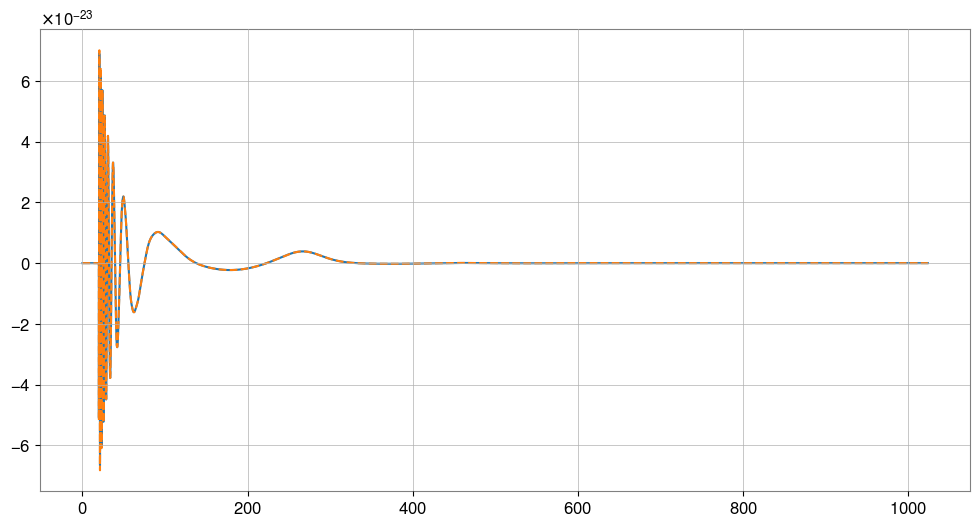

In [14]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(test1)
ax.plot(test2, '--')

# ax.set_xlim([10, 42])

plt.show()

Equal, good. As expected, conversion in inner_product works, so we can focus on what optimized_inner_product does

Note: this code was used when end of inner_product looked like this:
```
if optimize_time_and_phase:
    # Shit, problem: we cut f_range... But need start at zero for ifft -> maybe do in optimized_inner_product function?

    number_to_append = int((float(f_lower / f_lower.unit) - 0.0) / df_float)  # Symbolic -0.0 to make it clear what happens
    
    f_series_to_pad = FrequencySeries(
        np.zeros(number_to_append),
        unit=u.dimensionless_unscaled,
        f0=0.0,
        df=df,
        dtype=complex
    )

    signal1 = f_series_to_pad.append(signal1, inplace=False)
    signal2 = f_series_to_pad.append(signal2, inplace=False)

    # psd = f_series_to_pad.fill(1.0).append(psd, inplace=False)  # Otherwise division by zero. Contribution is zero anyway because signals are zero there
    f_series_to_pad.fill(1.0)  # No return here, thus has to be done separately
    psd = f_series_to_pad.append(psd, inplace=False)  # Otherwise division by zero. Contribution is zero anyway because signals are zero there

    # return optimized_inner_product(signal1, signal2, psd)
    return signal1, signal2, psd
    # TODO: decide if we divide by norm here? Or in overlap? Maybe do in
    # separate match function that always sets optimize_time_and_phase=True?
else:
    return inner_product_computation(signal1, signal2, psd)
```

In [15]:
match_series, match_val = optimized_inner_product(*inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True))
# match_series, match_val = optimized_inner_product(*inner_product(hp_t, hp_t, psd_gw150914, optimize_time_and_phase=True))

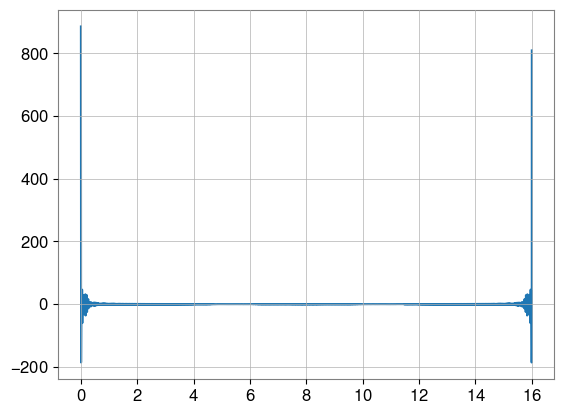

In [16]:
plt.plot(match_series)

plt.show()

In [446]:
hp_t_shifted = hp_t.copy()
# hp_t_shifted.times += 2.0 * u.s
hp_t_shifted.times += 10.0 * u.s
# hp_t_shifted.times += 100.0 * u.s

# hp_t_shifted.times += pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 0.96 * pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 1.1 * pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 0.5 * pad_to_get_target_df(hp_t, df=0.0625).duration  # This one is fun

# hp_t_shifted.times += hp_t.duration
# hp_t_shifted.times += 0.96 * hp_t.duration
# hp_t_shifted.times += 1.1 * hp_t.duration
# hp_t_shifted.times += 1.5 * hp_t.duration

match_series_v2, match_val_v2 = optimized_inner_product(*inner_product(hp_t, hp_t_shifted, psd_gw150914, df=2**-8, optimize_time_and_phase=True))

In [447]:
test2_1, test2_2, _ = inner_product(hp_t, hp_t_shifted, psd_gw150914, optimize_time_and_phase=True)

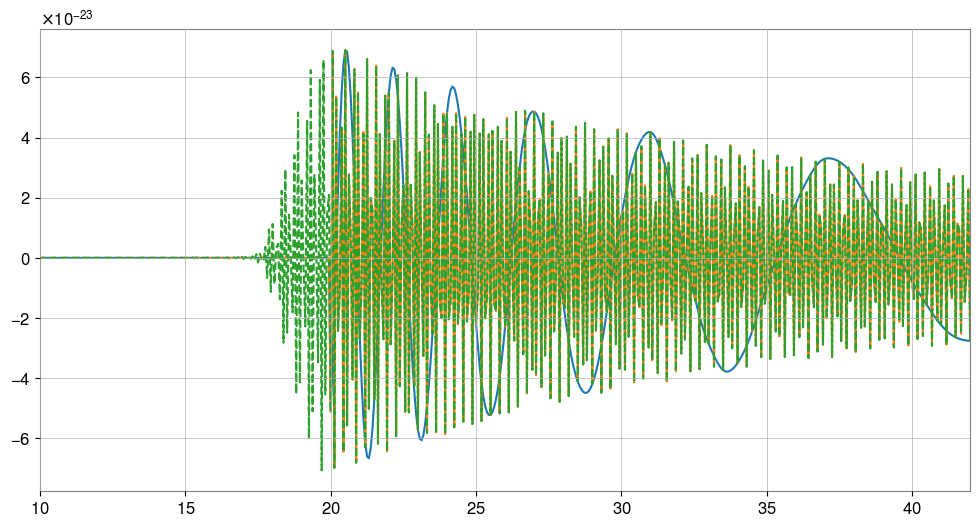

In [448]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(test2_1)
ax.plot(test2_2, '--')

ax.plot(td_to_fd_waveform(pad_to_get_target_df(hp_t_shifted, df=0.0625)), '--')

ax.set_xlim([10, 42])

plt.show()

Ohhh, it makes perfect sense that this overlap of frequency domain waveform and shifted time waveform is not the same. These two have different starting times!!! Therefore, the frequency domain waveforms are not equal and their overlap is not equal to their individual norm (the norms, on the other hand, are expected to be equal because the phase factors cancel)

Explanation why things get more equal as shift is increased: the oscillation in frequency domain has increased frequency (which is t0), so the sampled values have higher chance of actually coinciding with the envelope, i.e. the signal in frequency domain. This corresponds to an increasing overlap

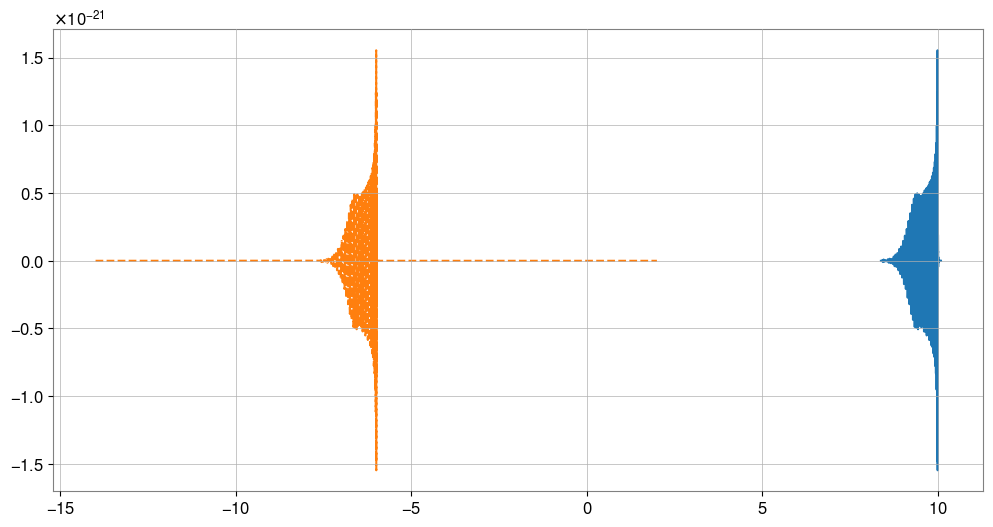

In [449]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t_shifted)

ax.plot(fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t_shifted, df=0.0625))), '--')

# ax.set_xlim([0, 2.1])

plt.show()

This is the problem. Does not start at $t = 0$, therefore we compute match of shifted signals

Note: as soon as shift gets larger than a certain threshold, we begin to see cyclic shift in context of Fourier transform (as soon as wrap-around affects significant parts of signal, i.e. those around merger). In this case means that the signal transformed to FD and back will not start at original starting time, but rather at starting time minus duration

In [450]:
print(hp_t.t0, hp_t_shifted.t0, hp_t_shifted.t0 - hp_t.t0)  # Confirmation everything has worked out

-1.615234375 s 8.384765625 s 10.0 s


In [451]:
print(ref_val, match_val, np.abs(match_val), match_val_v2, np.abs(match_val_v2))

885.2809011506321 (885.4997276952686+0j) Hz 885.4997276952686 Hz (868.5098141661367-2.842170943040401e-14j) Hz 868.5098141661367 Hz


In [452]:
print(inner_product(hp_t_shifted, hp_t_shifted, psd_gw150914))

885.2809011506321


Interesting. Absolute value here is same as result when taking rifft...

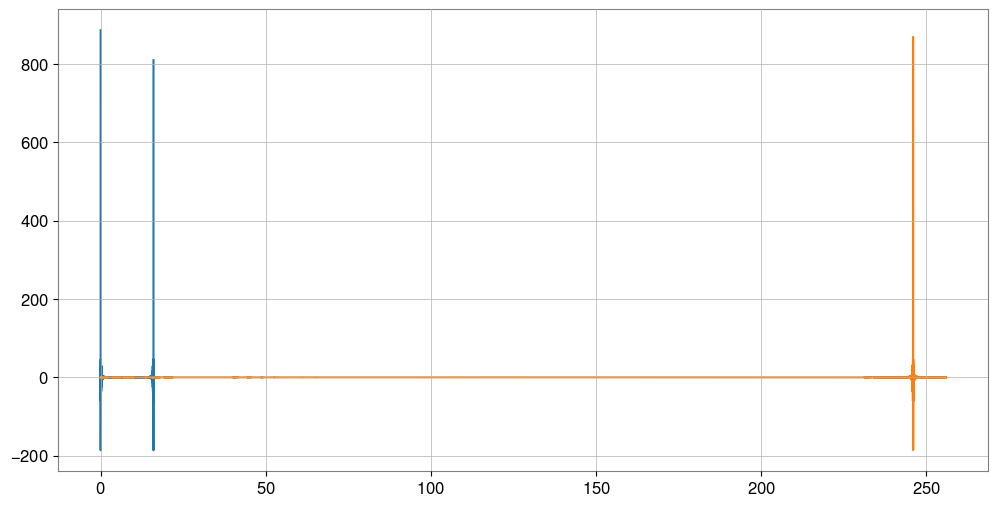

In [453]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(match_series)
ax.plot(match_series_v2)

plt.show()

Ok, nice. Peak at correct shift (see explanation below). But wrong height... Is pretty much a factor of two, sus.

Hmmm now it becomes more interesting: values are relatively equal, but they differ by factor of 2 from correct result... Is this due to different conventions with integration region?

In [454]:
print(np.sqrt(ref_val), np.sqrt(match_val), np.sqrt(np.abs(match_val)), np.sqrt(match_val_v2), np.sqrt(np.abs(match_val_v2)))

29.753670381158557 (29.75734745731327+0j) Hz(1/2) 29.75734745731327 Hz(1/2) (29.47049056541368-4.822062491175407e-16j) Hz(1/2) 29.47049056541368 Hz(1/2)


In [455]:
print(norm(hp_t_shifted, psd_gw150914))

29.753670381158557


Explanation of second peak (or single peak if only one is there):

In [456]:
print(pad_to_get_target_df(hp_t, df=hp_f_fine.df).duration, pad_to_get_target_df(hp_t_shifted, df=hp_f_fine.df).duration)
print(pad_to_get_target_df(hp_t, df=hp_f_fine.df).times[-1] - pad_to_get_target_df(hp_t_shifted, df=hp_f_fine.df).times[-1])

16.0 s 16.0 s
-10.0 s


Total length is 16s, so 14s is exactly the shift of 2s away from that. Probably has to do with the cyclic wrap-around that happens when going from FD to TD (for frequency components, shift of 2 or -2 makes no big difference).


So why is result for shifted ones different by non-negligible amount? Insufficient resolution maybe?

In [457]:
print(match_series.dt, match_series_v2.dt)

0.0004883259575766824 1 / Hz 0.0004883399303734084 1 / Hz


Nope, fairly small, that's definitely not the problem...

In [458]:
test_series_rfft = FrequencySeries(
    [1,2,3,4],
    frequencies=[0,1,2,3]
)

# test_series_fft = FrequencySeries(
#     [4,3,2,1,2,3,4],
#     frequencies=[-3,-2,-1,0,1,2,3]
# )
# This one has wrong ordering!!!



test_series_fft = FrequencySeries(
    [1,2,3,4,4,3,2],
    frequencies=[0,1,2,3,-3,-2,-1]
)

In [459]:
print(np.fft.irfft(test_series_rfft))
print(np.fft.ifft(test_series_fft))
# print(np.abs(np.fft.ifft(test_series_fft)))
print(np.real(np.fft.ifft(test_series_fft)))

FrequencySeries([ 2.5       , -0.66666667,  0.        ,
                 -0.16666667,  0.        , -0.66666667]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 1.0 Hz,
                epoch: None,
                name: None,
                channel: None)
FrequencySeries([ 2.71428571+0.j, -0.72127391+0.j,
                 -0.04399693+0.j, -0.09187202+0.j,
                 -0.09187202+0.j, -0.04399693+0.j,
                 -0.72127391+0.j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: None,
                epoch: None,
                name: None,
                channel: None)
FrequencySeries([ 2.71428571, -0.72127391, -0.04399693,
                 -0.09187202, -0.09187202, -0.04399693,
                 -0.72127391]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: None,
                epoch: None,
                name: None,
                channel: None)


In [460]:
print(np.fft.rfft(np.fft.irfft(test_series_rfft)))
print(np.fft.fft(np.fft.ifft(test_series_fft)))

FrequencySeries([1.+0.00000000e+00j, 2.+5.55111512e-17j,
                 3.+5.55111512e-17j, 4.+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 1.0 Hz,
                epoch: None,
                name: None,
                channel: None)
FrequencySeries([1.+0.j, 2.+0.j, 3.+0.j, 4.+0.j, 4.+0.j, 3.+0.j,
                 2.+0.j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: None,
                epoch: None,
                name: None,
                channel: None)


### Tests with match of two signals

In [463]:
hp_1, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'mass1': 10 * u.solMass, 'mass2': 20 * u.solMass}, gen)
hp_2, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'mass1': 10 * u.solMass, 'mass2': 20 * u.solMass}, gen)

In [464]:
optimized_inner_product(*inner_product(hp_1, hp_2, psd_gw150914, df=2**-8, optimize_time_and_phase=True))

(<TimeSeries([211.55479991+1.35308431e-16j,
              190.77433953-5.55978874e-16j,
              145.90030838-1.04603826e-15j, ...,
              102.98449793+6.24413715e-15j,
              145.90030838-7.58074159e-16j,
              190.77433953+3.58307134e-15j]
             unit=Unit("Hz"),
             t0=<Quantity 0. 1 / Hz>,
             dt=<Quantity 0.00048834 1 / Hz>,
             name=None,
             channel=None)>,
 <Quantity 211.55479991+1.35308431e-16j Hz>)

## PyCBC Comparisons

In [1]:
import pycbc

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
